<h1> ______________________________________ </h1>

<h1> Full NEXT100 with fiber panels simulation mapping analysis </h1>
<h1> ______________________________________ </h1>

<p style="font-size: 17px; color: black;"> In this Notebook we take as input the maps created in the previous notebook and use it to simulate an s2 signal for bb0nu events. </p>




<h1> ____________ </h1>
<h2> This version </h2>
<h1> ____________ </h1>

-  <p style="font-size: 17px; color: black;"> 100K ie S2 events. </p>
-  <p style="font-size: 17px; color: black;"> Mapping separated by sensors. </p>

-  <p style="font-size: 17px; color: black;"> Geant4 fundamental units: </p>

 -  <p style="font-size: 17px; color: black;"> Length [L]: mm (milimeter) </p>
 -  <p style="font-size: 17px; color: black;"> Time [T]: ns (nanosecond) </p>
 -  <p style="font-size: 17px; color: black;"> Energy [E]: MeV (megaelectronvolt) </p>





In [10]:
import numpy              as np
import pandas             as pd

import scipy              
from scipy                import stats, integrate
from scipy.signal         import convolve

import matplotlib.pyplot  as plt

from matplotlib.ticker    import FormatStrFormatter # to set the format of the plot's axis
from matplotlib.patches   import Rectangle # To add blanck spaces in tabular legends

import os
import math
import tables             as tb

# Functions

In [11]:
# Fitting distributions to define

# note: pdf are normilized to 1 so we have yo add an amplitude param
def gauss(x, a,  mu, sigma):
    return a*stats.norm.pdf(x, mu, sigma) 

def gauss_sum(x, a0,  mu0, sigma0, a1, mu1, sigma1):
    return a0*stats.norm.pdf(x, mu0, sigma0)  + a1*stats.norm.pdf(x, mu1, sigma1)


In [12]:
def s2_waveform(event, sensor):
    
    fig, ax = plt.subplots(nrows = 1, ncols = 1, figsize=(7, 7), constrained_layout=True)
    
    fontsize = 15
    ev = f'{event}'
    sens = f'sens_{sensor}'

    # Open the HDF5 file in read mode
    with h5py.File(filename, 'r') as file:

        # Get the group corresponding to the current key
        group = file[ev]


        # Get and print the value corresponding to the current subkey
        signal = group[sens][()]
        signal = pd.DataFrame(signal)
        signal.rename(columns = columns, inplace=True)



        t = signal.time*1e-3 # [us]
        s2 = signal.s2 # [e]
        
        bin_width = 1 # time units ([us])
        
        binin = np.arange(t.min() - bin_width, t.max() + 2*bin_width, bin_width)

        events, bins, bars = ax.hist(t, binin, 
                                     weights = s2,
                                     density=False,
                                     histtype='step')
        ax.set_title(f's2 of event {ev} in {sens}', fontsize = font_size);
        ax.set_xlabel('Time [us]', fontsize = font_size);
        ax.set_ylabel('Signal [e]', fontsize = font_size);

        ax.tick_params(axis='both', labelsize = font_size*2/3)
    
            

# Reading the file

In [18]:
path = '/home/investigator/mariandbt/python/data'
path = path + '/20231025_NEXT100_full_mapping'

# filename = os.path.join(path, "bb0nu_s2_signal.h5")
# filename = os.path.join(path, "20231215_bb0nu_s2_signal.h5")
# filename = os.path.join(path, "20231218_bb0nu_s2_signal.h5")
# filename = os.path.join(path, "20231220_bb0nu_100ev_s2_signal.h5")
filename = os.path.join(path, "20231226_bb0nu_100ev_s2_signal.h5")
# filename = os.path.join(path, "20240109_bb0nu_100ev_s2_signal.h5")
# filename = os.path.join(path, "20240113_bb0nu_200ev_s2_signal.h5")


In [19]:
with tb.open_file(filename) as file:
    print(file)

/home/investigator/mariandbt/python/data/20231025_NEXT100_full_mapping/20231226_bb0nu_100ev_s2_signal.h5 (File) ''
Last modif.: '2023-12-26T14:50:39+00:00'
Object Tree: 
/ (RootGroup) ''
/0 (Group) ''
/0/sens_200 (Array(99597, 2)) ''
/0/sens_201 (Array(99597, 2)) ''
/0/sens_202 (Array(99597, 2)) ''
/0/sens_203 (Array(99597, 2)) ''
/0/sens_204 (Array(99597, 2)) ''
/0/sens_205 (Array(99597, 2)) ''
/0/sens_206 (Array(99597, 2)) ''
/0/sens_207 (Array(99597, 2)) ''
/0/sens_208 (Array(99597, 2)) ''
/0/sens_209 (Array(99597, 2)) ''
/0/sens_210 (Array(99597, 2)) ''
/0/sens_211 (Array(99597, 2)) ''
/0/sens_212 (Array(99597, 2)) ''
/0/sens_213 (Array(99597, 2)) ''
/0/sens_214 (Array(99597, 2)) ''
/0/sens_215 (Array(99597, 2)) ''
/0/sens_216 (Array(99597, 2)) ''
/0/sens_217 (Array(99597, 2)) ''
/0/sens_218 (Array(99597, 2)) ''
/0/sens_219 (Array(99597, 2)) ''
/0/sens_220 (Array(99597, 2)) ''
/0/sens_221 (Array(99597, 2)) ''
/0/sens_222 (Array(99597, 2)) ''
/0/sens_223 (Array(99597, 2)) ''
/0/sens

In [21]:
# We read each file, make the histogram and save JUST the max value of that histogram in s2_max_dict

import h5py

# Load the 3D dictionary from the HDF5 file

columns = {0:'time',
           1:'s2'
          }

bin_width = 1000 # [ns] = 1 [us]
s2_max_dict = {} # s2 peak per sensor
full_s2_max_dict = {} # s2 peak per event

# Open the HDF5 file in read mode
with h5py.File(filename, 'r') as file:
    # Iterate through the top-level keys (groups) in the HDF5 file
    for key in file.keys():
        # Get the group corresponding to the current key
        group = file[key]
        full_s2 = []
        
        # Print the top-level key
        print(f'Top-level key: {key}')
        
        # Iterate through the subkeys (datasets) in the current group
        for subkey in group.keys():
            
            # Check if subkey is already in the dictionary
            if subkey not in s2_max_dict:
                s2_max_dict[subkey] = []
            
            # Get and print the value corresponding to the current subkey
            signal = group[subkey][()]
            signal = pd.DataFrame(signal)
            signal.rename(columns = columns, inplace=True)
            
            t = signal.time
            s2 = signal.s2
            binin = np.arange(t.min() - bin_width, t.max() + 2*bin_width, bin_width)
            
            # Create a histogram
            hist_values, bin_edges = np.histogram(t, bins=binin,
                                                  weights = s2)
            
#             print(f'Subkey: {subkey}, Value: {value}')

            full_s2.append(hist_values.max()) # peak of s2 signal
            s2_max_dict[subkey].append(hist_values.max()) # peak of s2 signal
    
        full_s2_max_dict[key] = max(full_s2)
            


Top-level key: 0
Top-level key: 1
Top-level key: 10
Top-level key: 11
Top-level key: 12
Top-level key: 13
Top-level key: 14
Top-level key: 15
Top-level key: 16
Top-level key: 17
Top-level key: 18
Top-level key: 19
Top-level key: 2
Top-level key: 20
Top-level key: 21
Top-level key: 22
Top-level key: 23
Top-level key: 24
Top-level key: 25
Top-level key: 26
Top-level key: 27
Top-level key: 28
Top-level key: 29
Top-level key: 3
Top-level key: 30
Top-level key: 31
Top-level key: 32
Top-level key: 33
Top-level key: 34
Top-level key: 35
Top-level key: 36
Top-level key: 37
Top-level key: 38
Top-level key: 39
Top-level key: 4
Top-level key: 40
Top-level key: 41
Top-level key: 42
Top-level key: 44
Top-level key: 45
Top-level key: 46
Top-level key: 47
Top-level key: 48
Top-level key: 49
Top-level key: 5
Top-level key: 50
Top-level key: 51
Top-level key: 52
Top-level key: 53
Top-level key: 54
Top-level key: 55
Top-level key: 56
Top-level key: 57
Top-level key: 58
Top-level key: 59
Top-level key: 6

In [22]:
len(s2_max_dict.values())
full_s2_max_dict

{'0': 1368.865782488043,
 '1': 3185.728692286393,
 '10': 785.6388453739901,
 '11': 2176.5865538919534,
 '12': 880.5142440291493,
 '13': 2809.7995722860214,
 '14': 2611.5436775694943,
 '15': 2083.626169141955,
 '16': 2038.176809323195,
 '17': 1383.3634832234675,
 '18': 1451.945989281658,
 '19': 1313.0345603064397,
 '2': 1015.9994194351902,
 '20': 2337.0737525861696,
 '21': 1949.188320535377,
 '22': 1095.4474694967248,
 '23': 1211.2384558201338,
 '24': 1023.1194100406938,
 '25': 1945.0179286199527,
 '26': 4027.6252592029778,
 '27': 2773.616592435981,
 '28': 1721.4076924937544,
 '29': 4478.305006280712,
 '3': 1560.4644189734881,
 '30': 3836.0794271108753,
 '31': 1914.2222590777674,
 '32': 839.9209368522265,
 '33': 777.3065479764773,
 '34': 638.9300303447344,
 '35': 1640.781458457408,
 '36': 2975.944985347538,
 '37': 816.9118957641404,
 '38': 3863.1943458996393,
 '39': 1623.7141393023812,
 '4': 4519.179554426304,
 '40': 1487.6879608484305,
 '41': 5741.486601370976,
 '42': 1367.948078904868

In [23]:
s2_max_dict.keys()
full_s2_max_dict.keys()


dict_keys(['0', '1', '10', '11', '12', '13', '14', '15', '16', '17', '18', '19', '2', '20', '21', '22', '23', '24', '25', '26', '27', '28', '29', '3', '30', '31', '32', '33', '34', '35', '36', '37', '38', '39', '4', '40', '41', '42', '44', '45', '46', '47', '48', '49', '5', '50', '51', '52', '53', '54', '55', '56', '57', '58', '59', '6', '60', '61', '62', '63', '64', '65', '66', '67', '68', '69', '7', '70', '71', '72', '73', '74', '75', '76', '77', '78', '79', '8', '80', '81', '82', '83', '84', '85', '86', '87', '88', '89', '9', '90', '91', '92', '93', '94', '95', '96', '97', '98', '99'])

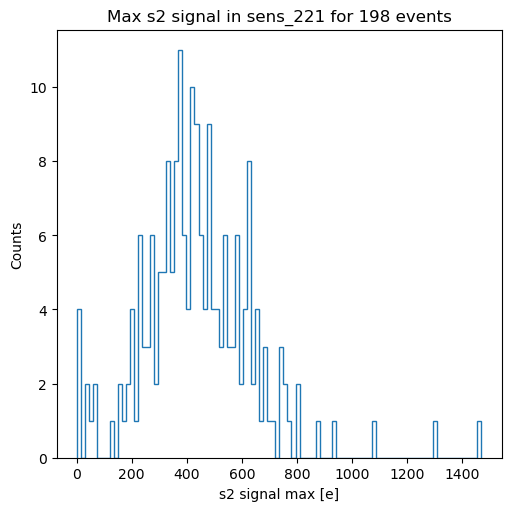

In [9]:
sensor = 'sens_221'

s2 = s2_max_dict[sensor]
s2 = np.array(s2)
n_events = np.size(s2)

fig, ax = plt.subplots(nrows = 1, ncols = 1, figsize=(5,5), constrained_layout=True)

bin_width = 1 # [e]
n_bins = 100
# binin = np.arange(s2.min() - bin_width, s2.max() + 2*bin_width, bin_width)
binin = n_bins

font_size = 8.5

events, bins, bars = ax.hist(s2, binin, 
                             density=False,
                             label='s2', 
                             histtype='step')

ax.set_title(f'Max s2 signal in {sensor} for {n_events} events');
ax.set_xlabel('s2 signal max [e]');
ax.set_ylabel('Counts');


In [10]:
subkey

'sens_289'

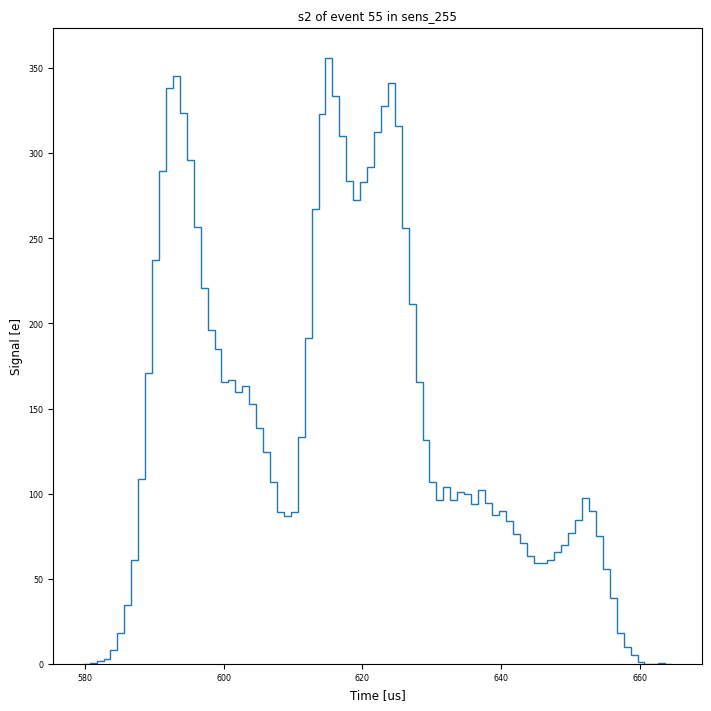

In [11]:
s2_waveform(55, 255)


In [18]:
len(h5py.File(filename, 'r').keys())

198

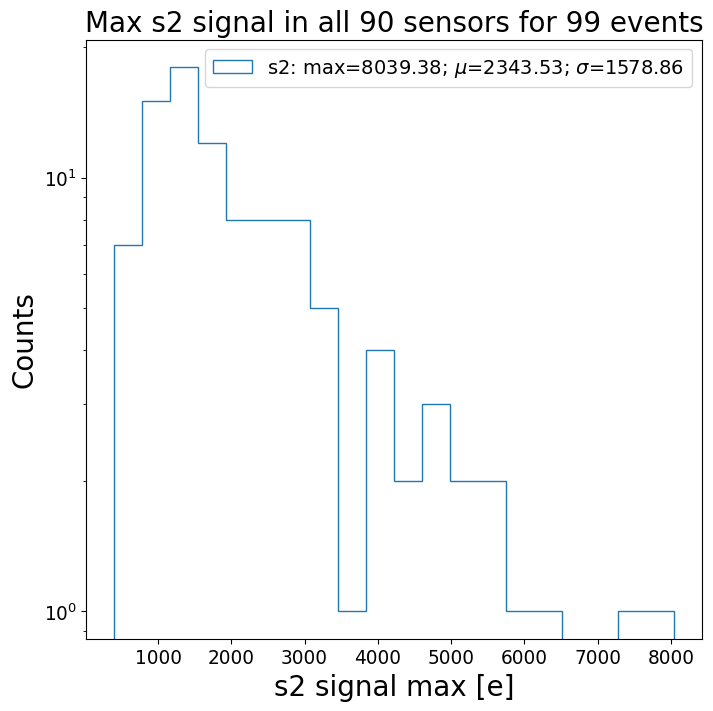

In [42]:
# s2 = np.array(list(s2_max_dict.values()))
s2 = np.array(list(full_s2_max_dict.values()))

n_events = np.shape(s2)[0]
# n_events = np.shape(s2)[1]
n_sensors = 90

# s2 = np.concatenate(s2)

fig, ax = plt.subplots(nrows = 1, ncols = 1, figsize=(7,7), constrained_layout=True)

bin_width = 1 # [e]
n_bins = 20
# binin = np.arange(s2.min() - bin_width, s2.max() + 2*bin_width, bin_width)
binin = n_bins

font_size = 20

events, bins, bars = ax.hist(s2, binin, 
                             density=False,
                             label='s2: max=%.2f; $\mu$=%.2f; $\sigma$=%.2f'%(s2.max(), s2.mean(), s2.std()), 
                             histtype='step')

ax.set_title(f'Max s2 signal in all {n_sensors} sensors for {n_events} events', fontsize = font_size);
ax.set_xlabel('s2 signal max [e]', fontsize = font_size);
ax.set_ylabel('Counts', fontsize = font_size);
ax.set_yscale('log')

ax.legend(fontsize=0.7*font_size, loc='best')

ax.tick_params(axis='both', labelsize = font_size*2/3)

Text(0, 0.5, 'Frequency')

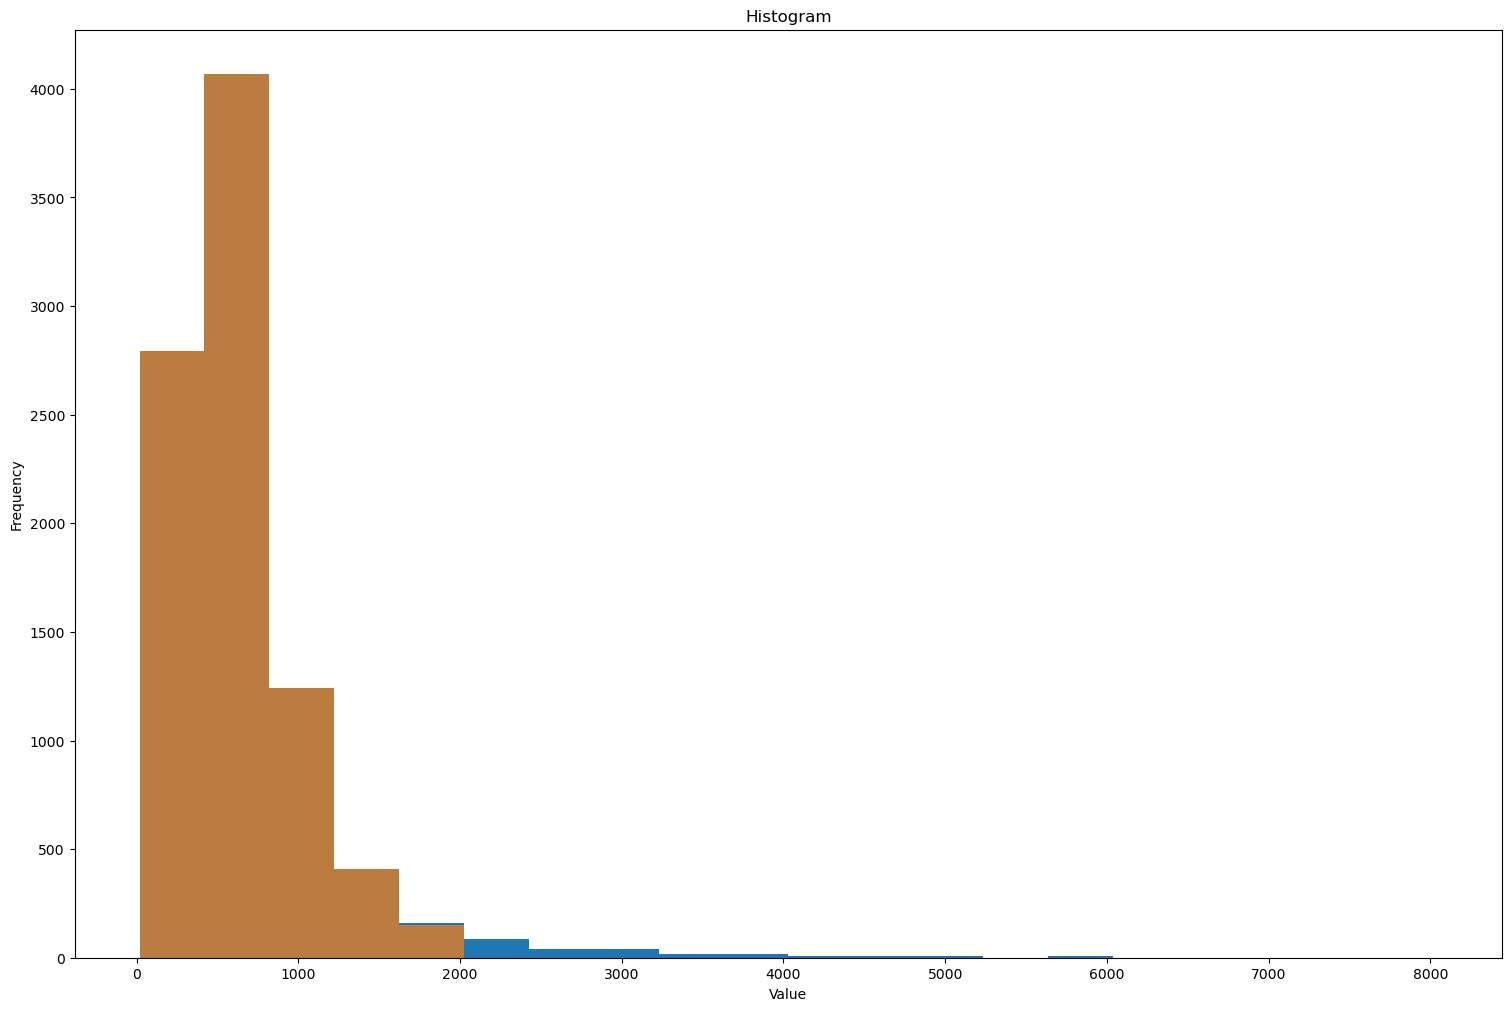

In [43]:
fig, ax = plt.subplots(nrows = 1, ncols = 1, figsize=(15,10), constrained_layout=True)

s2 = np.array(list(s2_max_dict.values()))
s2 = np.concatenate(s2)

# Create a histogram
events, bin_ref = np.histogram(s2, bins=binin)

# Plot the histogram
ax.hist((bin_ref[1:] + bin_ref[:-1])/2, bins=bin_ref,
         weights = events, 
         alpha=1)

# events, bins, bars = ax.hist(s2, binin, 
#                              density=False,
#                              alpha=0.7,
#                              histtype='step')

s2 = s2[s2 < 2000]
events, bins = np.histogram(s2, bins=bin_ref)
ax.hist((bins[1:] + bins[:-1])/2, bins=bin_ref,
         weights = events, 
         alpha=0.7)

# events, bins, bars = ax.hist(s2, binin, 
#                              density=False,
#                              alpha=0.7,
#                              histtype='step')

ax.set_title('Histogram')
ax.set_xlabel('Value')
ax.set_ylabel('Frequency')


In [44]:
# s2 = np.array(list(s2_max_dict.values()))
# s2 = np.concatenate(s2)
s2 = np.array(list(full_s2_max_dict.values()))

# Create a histogram
events_ref, bin_ref = np.histogram(s2, bins=binin)

cuts = np.arange(s2.max(), s2.min(), -500)
eff_dict = {}

for ii, cut in enumerate(cuts):
    
    s2 = s2[s2 < cut]
    events, bins = np.histogram(s2, bins=bin_ref)
    
    eff = events.sum()*100/events_ref.sum()
    
    eff_dict[cut] = eff
    


In [45]:
# eff_dict

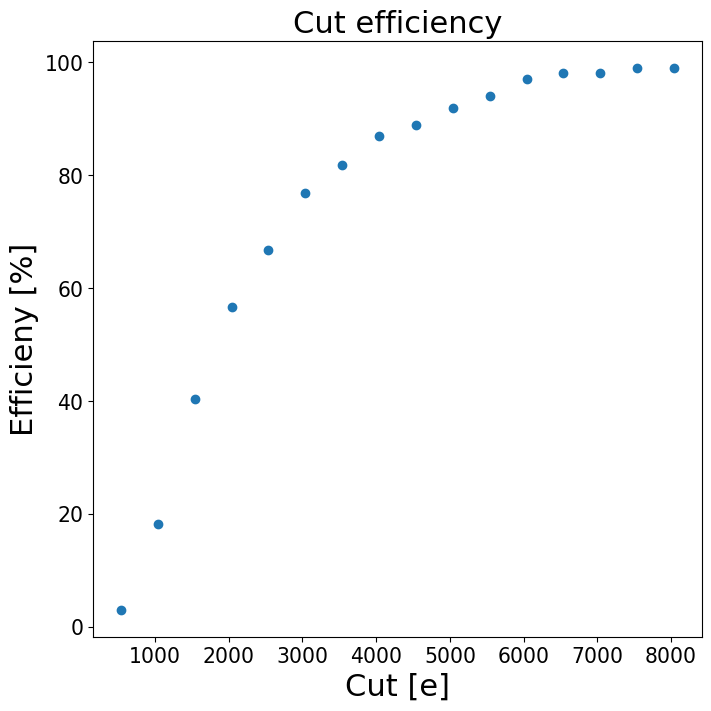

In [46]:
fig, ax = plt.subplots(nrows = 1, ncols = 1, figsize=(7, 7), constrained_layout=True)
font_size = 22

ax.plot(eff_dict.keys(), eff_dict.values(), 'o')
ax.set_title('Cut efficiency', fontsize = font_size)
ax.set_ylabel('Efficieny [%]', fontsize = font_size)
ax.set_xlabel('Cut [e]', fontsize = font_size)

ax.tick_params(axis='both', labelsize = font_size*2/3)
# ax.tick_params(axis='y', labelsize = font_size)
